In [1]:
from tsai.basics import *
import sktime
import sklearn
my_setup(sktime, sklearn)

os             : Linux-5.11.0-27-generic-x86_64-with-glibc2.17
python         : 3.8.12
tsai           : 0.3.1
fastai         : 2.6.3
fastcore       : 1.4.3
sktime         : 0.10.1
sklearn        : 1.0.2
torch          : 1.11.0
device         : 1 gpu (['NVIDIA GeForce RTX 3070 Laptop GPU'])
cpu cores      : 16
RAM            : 15.08 GB
GPU memory     : [8.0] GB


In [2]:
from fastcore.test import test_eq
from fastcore.basics import first
from fastai.data.external import untar_data, URLs
from fastai.tabular.data import TabularDataLoaders
from fastai.tabular.core import Categorify, FillMissing
from fastai.data.transforms import Normalize
import pandas as pd

In [3]:
from tsai.all import *

In [5]:
LSTMPlus

tsai.models.RNNPlus.LSTMPlus

In [6]:
df = pd.read_csv('dataset_with_rain_and_atm(1).csv')

In [7]:
# X - Признаки(данные без благовещенска)
# y - Предикт (Только Благовещенск), т.к. предсказываем для благовещенска
def create_multiple_dataset(df, num_days=365, days_forward=1):
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)-days_forward+1])
    new_X = np.concatenate(array_for_concat, axis=-1)
    y = df['Value-2366-zeya-blagoveshensk'].to_numpy().reshape(-1, 1)
    array_for_concat = []
    for i in range(days_forward):
        array_for_concat.append(y[num_days+i:y.shape[0] - (days_forward - i - 1)])
    new_y = np.concatenate(array_for_concat, axis=-1)
    
    return new_X, new_y

x_zavtra = 0

def help_function(df, num_days=365, days_forward=1):
    global x_zavtra
    number_of_frames = df[df.keys()[1:]].to_numpy().shape[1]
    X = df[df.keys()[1:]].to_numpy().reshape(-1, number_of_frames, 1)
    array_for_concat = []
    for i in range(num_days):
        array_for_concat.append(X[i:X.shape[0]-(num_days - i)-days_forward+2])
    new_X = np.concatenate(array_for_concat, axis=-1)
    x_zavtra = new_X[-1:]
    new_X = new_X[:-1]
    #y = df['Value-2366-zeya-blagoveshensk'].to_numpy().reshape(-1, 1)
    '''array_for_concat = []
    for i in range(days_forward):
        array_for_concat.append(y[num_days+i:y.shape[0] - (days_forward - i - 1)])
    new_y = np.concatenate(array_for_concat, axis=-1)'''
    
    return new_X


def create_data_set_without_blagoveshensk(df, num_days=365, days_forward=1):
    X, y = create_multiple_dataset(df, num_days,  days_forward)
    X = help_function(df, num_days, days_forward)
    return X, y

#df_without_blagoveshensk = df[['zeya-malayasazanka', 'zeya-svobodny', 'zeya-mazanovo', 'zeya-belogorye']]
#df_only_blagoveshensk = df[['zeya-blagoveshensk']]
X, y = create_data_set_without_blagoveshensk(df)
X.shape

(4384, 19, 365)

In [8]:
y = y.reshape(-1)

In [9]:

batch_tfms = TSStandardize()

stratify set to False because shuffle=False. If you want to stratify set shuffle=True


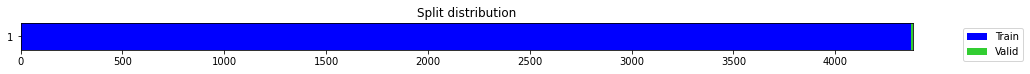

In [10]:
n_splits                = 5
valid_size              = 10 / X.shape[0]
test_size               = 0.0
train_only              = False  # set to True for debugging (valid = train)
train_size              = 4374
stratify                = True
balance                 = False
shuffle                 = False
predefined_splits       = None
show_plot               = True 


check_splits = True
random_state = 23


splits = get_splits(y, train_size=train_size, valid_size=valid_size, test_size=test_size, shuffle=shuffle,
                    train_only=train_only, random_state=random_state, show_plot=show_plot, verbose=True)

epoch,train_loss,valid_loss,time
0,32609.558594,17093.082031,00:01
1,32105.484375,16927.128906,00:00
2,31756.994141,16714.099609,00:00
3,31661.035156,16484.900391,00:00
4,31449.109375,16242.150391,00:00
5,30630.273438,15995.645508,00:00
6,30410.583984,15761.846680,00:00
7,30336.193359,15521.789062,00:00
8,30549.863281,15284.640625,00:00
9,30230.033203,15030.387695,00:00


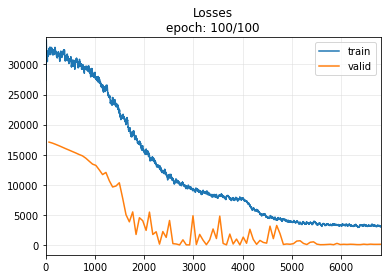

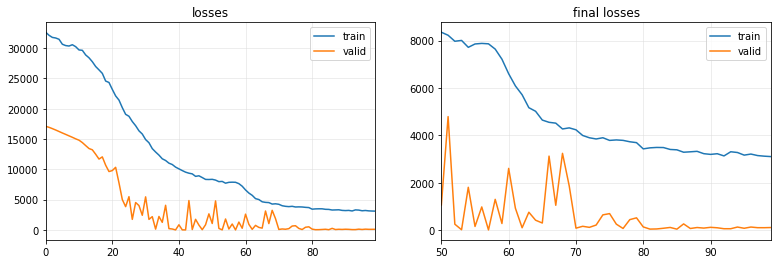

In [34]:
clf = TSForecaster(X, y, splits=splits, arch=LSTM_FCN, batch_tfms=batch_tfms, cbs=ShowGraph())
clf.fit_one_cycle(100, 3e-4)

In [41]:
clf.save('LSTM_FCN')

Path('models/LSTM_FCN.pth')

In [42]:
clf.load('LSTM_FCN')

In [35]:
y_predict = clf.get_X_preds(X)[0].numpy()
y_valid_predict = y_predict[-10:]

In [27]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [28]:
import matplotlib.pyplot as plt

In [36]:
y_valid = y[-10:]

In [37]:

rmse = mean_squared_error(y_valid, y_valid_predict, squared=False)
mae = mean_absolute_error(y_valid, y_valid_predict)

print(f'valid rmse        : {rmse:.5f}')
print(f'valid mae        : {mae:.5f}')

valid rmse        : 10.62838
valid mae        : 8.40082


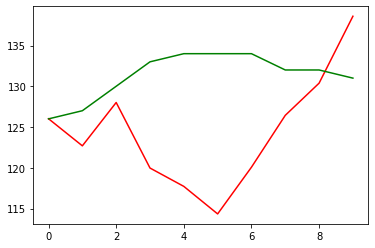

In [38]:
x = list(range(0, len(y_valid_predict)))
np.reshape(x, (len(x), 1))
plt.plot(x, y_valid_predict, 'r')
plt.plot(x, y_valid, 'g')
plt.show()

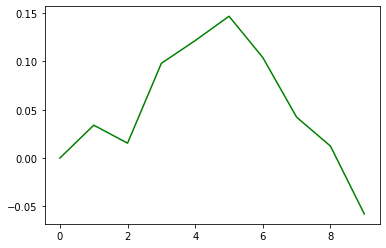

In [39]:
x = list(range(0, len(y_valid_predict)))
np.reshape(x, (len(x), 1))
error = (y_valid.reshape(-1) - y_valid_predict.reshape(-1)) / y_valid.reshape(-1)
plt.plot(x, error, 'g')
plt.show()

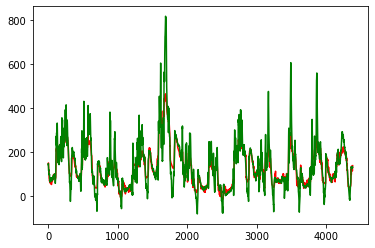

In [40]:
x = list(range(0, len(y)))
np.reshape(x, (len(x), 1))
plt.plot(x, y_predict, 'r')
plt.plot(x, y, 'g')
plt.show()